In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8833836338316893506]

In [ ]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
#from cv2 import imread
#from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

<h1> mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/My Drive/DL/teamproject"

/content/drive/My Drive/DL/teamproject


<h1> data 불러오기 - 경로 설정

In [ ]:
# # Now set the working path of your data, so that you can access it later on.
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'DL_data/data/')

In [ ]:
#!unzip -qq "/content/drive/My Drive/DL/teamproject/DL_data.zip"

In [ ]:
data_dir="/content/drive/My Drive/DL/teamproject/"

<h1> data 불러오기 - imagedatagenerator

In [ ]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(data_dir,color_mode="rgb",class_mode="input",
        target_size=(180,180), batch_size=256)

Found 10143 images belonging to 3 classes.


In [ ]:
filenames = train_generator.filenames
nb_samples = len(filenames)
#
#predict = model.predict_generator(test_generator,nb_samples)#

<h1> pretrained model - ResNet50

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Input, Activation,Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import Sequential
from sklearn.cluster import KMeans

model = ResNet50(weights='imagenet', include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
batch_size=256
ResNet_feature = model.predict_generator(train_generator,nb_samples)

print(ResNet_feature.shape)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(10143, 6, 6, 2048)


In [ ]:
#kmeans clustering 을 위해 reshape
new_feautures = ResNet_feature.reshape((ResNet_feature.shape[0], -1))
new_feautures.shape

(10143, 73728)

<h1> KMeans Clustering 적용

최적의 k를 찾기 위해 sillhouette 계수를 활용 - plot

In [ ]:
km = KMeans(n_clusters=10, random_state=0).fit(new_feautures)

In [ ]:
km.labels_[:10]

array([3, 3, 1, 8, 7, 1, 1, 5, 2, 4], dtype=int32)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil=[]
kmax=9
for k in range(3, kmax+1):
  kmeans = KMeans(n_jobs=1,n_clusters = k,n_init=20).fit(new_feautures) # n_clusters=10, 
  labels = kmeans.labels_
  sil.append(silhouette_score(new_feautures, labels, metric = 'euclidean'))

In [ ]:
sil

[0.11000354,
 0.08984565,
 0.07058632,
 0.04867079,
 0.044217754,
 0.040935233,
 0.035347473]

In [ ]:
labels.shape

(10143,)

<h1>실루엣계수

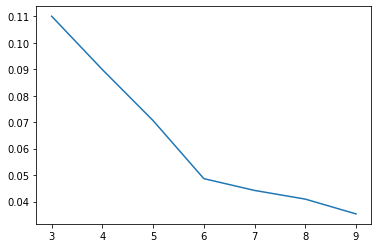

In [ ]:
import matplotlib.pyplot as plt
k=list(range(3, kmax+1))
plt.plot(k, sil)

In [ ]:
temp_features=[str(feature) for feature in new_feautures]

In [ ]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(new_feautures, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
temp = pd.DataFrame({'ResNet_features': temp_features})
temp.to_csv("ResNet_feature.csv", encoding="utf-8")

In [ ]:
input = Input(shape=(180, 180, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')
 
x = model.output

encoded = Dense(500, activation='relu')(x)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500)(decoded)

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(decoded)


autoencoder = Model(model.input, decoded)
for layer in model.layers:
    layer.trainable = False

ValueError: ignored

In [ ]:
autoencoder.summary()

In [ ]:
#pred_auto_train = autoencoder.predict(x_train)
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20)
#km.fit(pred_auto_train)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(train_generator,
        steps_per_epoch=2000,
        epochs=10,
        validation_data=val_generator,
        validation_steps=800)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:

# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 2e4
tol = 0.001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 500
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[x_train.shape[-1], 500, 500, 2000, 10], n_clusters=10, init=init)

#dec.pretrain(x=train_x, y=train_y, optimizer=pretrain_optimizer,
#             epochs=pretrain_epochs, batch_size=batch_size,
#             save_dir=save_dir)

TypeError: ignored

In [ ]:
x_train.shape[-1]

784

In [ ]:
dec.model.summary()

In [ ]:

# Now instead of directly applying K-Means on the problem, we will first use an autoencoder to decrease the dimensionality of the data and extract useful information. This will then pass on the information to the K-Means algorithm.
# this is our input placeholder
input_img = Input(shape=(150, 150, 3))
compression = 10

# "encoded" is the encoded representation of the input
flatten = Flatten()(input_img)
encoded = Dense(int(np.floor(28*28)), activation='relu')(flatten)
encoded = Dense(500, activation='relu')(encoded)

encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

NameError: ignored

In [ ]:
input = Input(shape=(28, 28, 3))
base_model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')
 
x = model.output

encoded = Dense(500, activation='relu')(x)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500)(decoded)

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(decoded)


autoencoder = Model(model.input, decoded)
for layer in model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation,Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
#img_shape=(28,28,3)
from keras import Sequential

input = Input(shape=(150, 150, 3))
base_model = ResNet50(input_tensor=input, include_top=False, weights="imagenet", pooling='max') 

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(2000, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))
model.add(layers.Dense(2000, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Conv2D(3, (150,150), activation='relu', padding='same'))

ValueError: ignored

In [ ]:
base_model.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='input')

validation_generator = test_datagen.flow_from_directory(data_dir,
                                                        target_size=(150,150),
                                                        batch_size=20,
                                                        class_mode='input')



Found 10143 images belonging to 1 classes.
Found 10143 images belonging to 1 classes.


In [ ]:
model.compile(loss='mse',
              optimizer=optimizers.RMSprop(lr=1e-4))

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30


InvalidArgumentError: ignored